# Media Analysis Challenge - Complete Notebook

This notebook addresses all 7 challenges for analyzing media data:
1. Data Cleaning
2. Sentiment Analysis
3. Trend Visualization
4. Topic Identification
5. Word Cloud Visualization
6. Summary Insights
7. Export Results

# 📥 **Import Libraries**

In [521]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [522]:
# Import necessary libraries
import pandas as pd
import numpy as np
import glob # added to find files matching a patter like .csv
import os # For file system operations (like joining paths or getting filenames)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from thefuzz import process
import re
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage


# For sentiment analysis
from textblob import TextBlob

# For word clouds
from wordcloud import WordCloud

# For topic analysis
from collections import Counter
import re

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)
print("✅ Libraries imported")

✅ Libraries imported


In [523]:
# --- Global list to store plot filenames ---
plot_files = []

def save_and_show_plot(fig, filename):
    """Save a matplotlib figure, show it, and store filename for Excel export."""
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plot_files.append(filename)
    plt.close(fig)
print("Ready to save images...")

Ready to save images...


In [524]:
## For keywords standardization

!pip install thefuzz[speedup]

# 🧩 **Challenge 1: Data Cleaning**

---

## 🔍 **Data Inspection**

In [525]:
# Folder Path
folder_path = '/content/drive/MyDrive/Group 3'  # Add shortcut of this folder inside your "My Drive": https://drive.google.com/drive/folders/1inmbzxNOOo9El0JMG6_eNyTbbZNYRoCb?usp=sharing
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Initialize
datasets_sample = {}
file_encodings = {}
all_column_sets_sample = []

# Load sample rows
sample_size = 5

for file in all_files:
    df_temp = None
    file_name = os.path.basename(file)

    for enc in ["utf-8", "utf-16", "latin-1"]:
        try:
            df_temp = pd.read_csv(
                file,
                encoding=enc,
                engine="python",
                sep=None,             # auto-detect delimiter
                on_bad_lines="skip"   # skip malformed rows
            )
            file_encodings[file_name] = enc
            break
        except Exception:
            continue

    if df_temp is not None:
        datasets_sample[file_name] = df_temp
        all_column_sets_sample.append(set(col.strip().lower() for col in df_temp.columns))
    else:
        print(f"⚠️ Skipped {file_name} (could not be read).")

# Collect all unique raw column names from all files
all_raw_columns = set().union(*all_column_sets_sample)

print(f"🔎 Found {len(all_raw_columns)} unique raw column names across files:")
print(sorted(all_raw_columns))

print(f"✅ Loaded {len(datasets_sample)} files. Ready to inspect")
total_rows = sum(len(df) for df in datasets_sample.values() if df is not None)
print(f"📊 Total Rows: {total_rows:,}\n")

# Print per file info
for file_name, df in datasets_sample.items():
    enc = file_encodings.get(file_name, "unknown")
    print(f"📂 {file_name}")
    print(f"   ➡ Records: {len(df):,} rows | {df.shape[1]} columns")
    print(f"   ➡ Loaded with encoding {enc}")
    print(f"   ➡ Preview of the first {sample_size} rows:")
    display(df.head(sample_size))
    print("\n")  # blank space between files

# adjust column mapping if needed based on the results.

🔎 Found 52 unique raw column names across files:
['alternate date format', 'ave', 'city', 'comments', 'country', 'custom categories', 'desktop reach', 'document id', 'document tags', 'editorial echo', 'engagement', 'estimated views', 'facebook social echo', 'headline', 'hit sentence', 'influencer', 'input name', 'is verified', 'key phrases', 'keywords', 'language', 'likes', 'mobile reach', 'national viewership', 'opening text', 'parent url', 'reach', 'reactions', 'reddit social echo', 'replies', 'retweets', 'sentiment', 'shares', 'social echo total', 'source', 'state', 'subregion', 'threads', 'time', 'timestamp', 'tweet id', 'twitter authority', 'twitter bio', 'twitter client', 'twitter followers', 'twitter following', 'twitter id', 'twitter screen name', 'twitter social echo', 'url', 'user profile url', 'views']
✅ Loaded 1 files. Ready to inspect
📊 Total Rows: 3,846

📂 Shoes.xlsx - Export.csv
   ➡ Records: 3,846 rows | 52 columns
   ➡ Loaded with encoding utf-8
   ➡ Preview of the fir

,Timestamp,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,Language,Reach,Desktop Reach,Mobile Reach,Twitter Social Echo,Facebook Social Echo,Reddit Social Echo,National Viewership,Engagement,AVE,Sentiment,Key Phrases,Input Name,Keywords,Twitter Authority,Tweet Id,Twitter Id,Twitter Client,Twitter Screen Name,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Social Echo Total,Editorial Echo,Views,Estimated Views,Likes,Replies,Retweets,Comments,Shares,Reactions,Threads,Is Verified,Parent URL,Document Tags,Document ID,Custom Categories
0,31-Jul-2025 10:44PM,NaN,https://twitter.com/Mlfreeman75/statuses/19509...,RT @JohnFairfax11: @TONYxTWO Companies with Ca...,RT @JohnFairfax11: @TONYxTWO Companies with Ca...,Twitter,@mlfreeman75,Unknown,NaN,English,1807.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.71,Neutral,centers,Philippines AND (Nike OR Adidas OR New Balance),"Philippines,Nike",6.0,"""1950930540401439146""","""1487082337322029061""",NaN,Melissa Freeman,https://twitter.com/Mlfreeman75,NaN,1807.0,2041.0,31-Jul-25,10:44 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,https://twitter.com/JohnFairfax11/statuses/195...,NaN,"""1753973062000_sCfTGCEsmSussjTK2bglRcge8OwA""",NaN
1,31-Jul-2025 10:33PM,NaN,https://twitter.com/bobbypup/statuses/19509277...,RT @vdasoccer: Congratulations to Otu Bisong o...,RT @vdasoccer: Congratulations to Otu Bisong o...,Twitter,@bobbypup,United States,NaN,English,10886.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.70,Positive,vda team,Philippines AND (Nike OR Adidas OR New Balance),"Adidas,Philippines",8.0,"""1950927710622019868""","""25021718""",NaN,Bobby Puppione,https://twitter.com/bobbypup,Husband to @makoski22. Cali Born / Bama Grad. ...,10886.0,6210.0,31-Jul-25,10:33 PM,"Washington, D.C.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,https://twitter.com/vdasoccer/statuses/1950919...,NaN,"""1753972387000_hMO3ZbtLDsuxyDqEy0Lc3uiR6doA""",NaN
2,31-Jul-2025 10:30PM,NaN,https://twitter.com/Momofbabykevin/statuses/19...,RT @JohnFairfax11: @TONYxTWO Companies with Ca...,RT @JohnFairfax11: @TONYxTWO Companies with Ca...,Twitter,@momofbabykevin,Unknown,NaN,English,243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.25,Neutral,centers,Philippines AND (Nike OR Adidas OR New Balance),"Philippines,Nike",5.0,"""1950927069342494903""","""1918465002983636992""",NaN,Kevin's Mom,https://twitter.com/Momofbabykevin,NaN,243.0,78.0,31-Jul-25,10:30 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,https://twitter.com/JohnFairfax11/statuses/195...,NaN,"""1753972234000_V7IszrTcnb331Ii2aiwCudf053MA""",NaN
3,31-Jul-2025 10:00PM,NaN,https://twitter.com/vdasoccer/statuses/1950919...,Congratulations to Otu Bisong of the 06/07B VD...,Congratulations to Otu Bisong of the 06/07B VD...,Twitter,@vdasoccer,United States,NaN,English,2572.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,23.79,Positive,"adidas rising star award,vda team",Philippines AND (Nike OR Adidas OR New Balance),"Adidas,Philippines",7.0,"""1950919381514629349""","""3994978756""",NaN,Virginia DevAcademy,https://twitter.com/vdasoccer,#Vision #Inspire #Accountability #Collaboratio...,2572.0,141.0,31-Jul-25,10:00 PM,Virginia,Virginia Beach,NaN,NaN,364.0,NaN,6.0,NaN,2.0,NaN,2.0,6.0,NaN,True,NaN,NaN,"""1753970401000_xctxuue28zpqXlCN-I1Zw_-W-YAA""",NaN
4,31-Jul-2025 09:45PM,Purple Heart Day is coming to honor America’s ...,https://www.floydct.com/news/national/purple-h...,Purple Heart Day arrives to honor America’s wo...,"... of service, enemy forces captured him duri...",Floyd County Times,Zuzana Paar,United States,Kentucky,English,4526.0,918.0,3608.0,0.0,0.0,0.0,NaN,NaN,41.87,Positive,"civilian life,collective costs,connect with ve...",Philippines AND (Nike OR Adidas OR New Balance),"Adidas,Philippines",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31-Jul-25,9:45 PM,Kentucky,Prestonsburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""TgGuW93kGWTiLlHS2tCpPT_cBos""",NaN


## 🛠️ **Setup + Cleaning**



In [526]:
# --- Setup  ---
folder_path = '/content/drive/MyDrive/Group 3'
chunk_size = 100000 # adjust based on your preference.

# Standardization of Datasets (To help have a structured columns, and drop unnecessary ones)
standard_columns = [
    "Date", "Headline", "URL", "Opening Sentence", "Hit Sentence", "Source",
    "Influencer", "Country", "Language", "Reach", "Twitter Social Echo",
    "Facebook Social Echo", "Engagement", "AVE", "Sentiment", "Key Phrases",
    "Input Name", "Keywords", "Document ID"
]

# Define column mappings (Some exports could have a different header)
column_mapping = {
    "location": "Country",
    "timestamp": "Date",
    "opening text": "Opening Sentence",
    "date": "Date",
    "document id": "Document ID",
    "headline": "Headline",
    "url": "URL",
    "opening tex": "Opening Sentence",
    "hit sentence": "Hit Sentence",
    "source": "Source",
    "country": "Country",
    "language": "Language",
    "reach": "Reach",
    "twitter social echo": "Twitter Social Echo",
    "facebook social echo": "Facebook Social Echo",
    "engagement": "Engagement",
    "ave": "AVE",
    "sentiment": "Sentiment",
    "key phrases": "Key Phrases",
    "input name": "Input Name",
    "keywords": "Keywords"
    # add more mappings as needed
}

standardized_datasets = {}

# --- Find all CSV files ---
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Dictionary to store processed chunks per file
processed_chunks = {}

print(f"Successful!")

Successful!


### 📊 **Column Standardization**

In [527]:
# --- Chunked processing + preprocessing ---
for file in all_files:
    file_name = os.path.basename(file)
    print(f"\n🔄 Processing file: {file_name}")
    chunk_list = []

    for enc in ["utf-8", "utf-16", "latin-1"]:
            try:
                pd.read_csv(
                    file,
                    encoding=enc,
                    engine="python",
                    sep=None,             # auto-detect delimiter
                    on_bad_lines="skip",   # skip malformed rows
                    nrows=5
                )
                enc_used = enc
                break  # stop trying other encodings once it works
            except Exception:
                continue

    if not enc_used:
        print(f"⚠️ Skipped {file_name} (could not be read).")
        continue

    try:
        chunk_iter = pd.read_csv(
            file,
            encoding=enc_used,
            engine="python",
            sep=None,                # auto-detect delimiter
            chunksize=chunk_size,
            on_bad_lines="skip"
        )

        for chunk in chunk_iter:
            # Normalize headers (lowercase for consistent mapping)
            chunk.columns = [col.strip().lower() for col in chunk.columns]
            column_mapping_lower = {k.lower(): v for k, v in column_mapping.items()}

            # Apply column mapping
            chunk.rename(columns={c: column_mapping_lower.get(c, c) for c in chunk.columns}, inplace=True)

            # Remove blank URLs
            if "URL" in chunk.columns:
                chunk = chunk[chunk["URL"].notnull() & (chunk["URL"].str.strip() != "")]
            if chunk.empty:
                continue

            # Align with standard schema
            chunk = chunk.reindex(columns=standard_columns)

            chunk_list.append(chunk)


        if chunk_list:
            df_combined = pd.concat(chunk_list, ignore_index=True)
            processed_chunks[file_name] = df_combined
            print(f"✅ {file_name}: {len(chunk_list)} chunks processed, {len(df_combined)} rows total.")
            print("📊 Sample rows:")
            print(df_combined.head(5).to_string(index=False))
        else:
            print(f"⚠️ {file_name}: no valid chunks found.")

    except Exception as e:
        print(f"⚠️ Failed chunking {file_name}: {e}")

        # 🔹 Merge engagement-related metrics here
    engagement_cols = [
        "likes", "shares", "comments", "retweets", "replies",
        "reactions", "threads"
    ]
    valid_engagement_cols = [c for c in engagement_cols if c in chunk.columns]
    if valid_engagement_cols:
        # If "Engagement" already exists, add onto it
        chunk["Engagement"] = chunk.get("Engagement", 0).fillna(0) + chunk[valid_engagement_cols].fillna(0).sum(axis=1)

print("\n✅ All files loaded, standardized, and blank URLs removed.")


🔄 Processing file: Shoes.xlsx - Export.csv
✅ Shoes.xlsx - Export.csv: 1 chunks processed, 3842 rows total.
📊 Sample rows:
               Date                                                       Headline                                                                                                                                                    URL                                                                                                                                 Opening Sentence                                                                                                                                                                                                                                Hit Sentence             Source  Influencer       Country Language   Reach  Twitter Social Echo  Facebook Social Echo  Engagement    AVE Sentiment                                                                                                                                 

### 🌐 **Normalize Source Name**

In [528]:
import re
from rapidfuzz import process
import pandas as pd

# --- Canonical sources ---
CANONICAL_SOURCES = [
    "CNN",
    "BBC",
    "Reuters",
    "Bloomberg",
    "Guardian",
    "New York Times",
    "X",                 # Twitter
    "Sporting News",
    "MarketScreener",
    "MSN",
    "Fashion Network",
    "Reddit",
    "Yahoo! Finance",
    "ABC News",
    "Wall Street Journal",
    "Forbes",
    "ABS-CBN",
    "Vogue",
]

# --- Helper to clean and normalize raw source names ---
def clean_name(name: str) -> str:
    name = str(name).lower().strip()

    # Remove domains
    name = re.sub(r"\.com|\.org|\.net", "", name)
    name = name.replace("www.", "")

    # Remove anything after /, |, or -
    name = re.split(r"[\/|\-]", name)[0]

    # Remove parentheses content
    name = re.sub(r"\s*\([^)]*\)", "", name)

    # Remove trailing region/country/edition keywords
    name = re.sub(
        r"\b(au|ca|india|uk|us|canada|france|philippines|malaysia|ireland|"
        r"south africa|singapore|world wide|print edition|licensed by copyright agency)\b",
        "",
        name
    )

    # Remove extra punctuation and collapse spaces
    name = re.sub(r"[•.,]", "", name)
    name = re.sub(r"\s+", " ", name)

    return name.strip()

# --- Main normalization function ---
def normalize_source(source: str, threshold: int = 80) -> str:
    if pd.isna(source):
        return source

    cleaned = clean_name(source)

    # Special map for tricky aliases
    special_map = {
        "nytimes": "New York Times",
        "ny times": "New York Times",
        "the guardian": "Guardian",
        "twitter": "X",
        "fashionnetwork": "Fashion Network",
        "msn": "MSN",
        "reddit": "Reddit",
        "yahoo!": "Yahoo! Finance",
        "abc news": "ABC News",
        "wsj": "Wall Street Journal",
        "forbes": "Forbes",
        "Bbc Vietnamese" : "BBC",
        "Vogue Business" : "Vogue",
        "Vogue Italia" : "Vougue",
        "Vogue Japan" : "Vogue",
        "Vogue Korea" : "Vogue",
        "Vogue Mexico" : "Vogue"
    }
    if cleaned in special_map:
        return special_map[cleaned]

    # Fuzzy match
    result = process.extractOne(cleaned, CANONICAL_SOURCES, score_cutoff=threshold)
    if result is None:
        return source.title()  # fallback

    match, score, _ = result
    return match

# --- Apply normalization to your dataset ---
print("🔄 Normalizing source names...\n")

for fname, df in processed_chunks.items():
    print(f"\n📂 File: {fname}")
    print(f"Unique sources before normalization: {df['Source'].nunique()}")
    print("\nTop 10 sources before normalization:")
    print(df['Source'].value_counts().head(10))

    df["Source_Normalized"] = df["Source"].apply(normalize_source)

    print(f"\nUnique sources after normalization: {df['Source_Normalized'].nunique()}")
    print("\nTop 10 sources after normalization:")
    print(df["Source_Normalized"].value_counts().head(10))

    # Print all normalized sources
    print("\n✅ All normalized sources:")
    for src in sorted(df["Source_Normalized"].unique()):
        print(f"- {src}")

    # Print unmatched sources
    unmatched = df.loc[
        ~df["Source_Normalized"].isin(CANONICAL_SOURCES),
        "Source_Normalized"
    ].value_counts()

    if len(unmatched) > 0:
        print("\n⚠️ Unmatched sources (review these for possible new canonical entries):")
        for src, count in unmatched.items():
            print(f"- {src} ({count})")
    else:
        print("\n🎉 All sources matched canonical list!")


🔄 Normalizing source names...


📂 File: Shoes.xlsx - Export.csv
Unique sources before normalization: 868

Top 10 sources before normalization:
Source
Twitter                          2248
Tiktok                            142
Youtube                            68
Forums                             35
Facebook                           30
Open PR                            27
Vogue México                       23
Vogue Italia                       22
Audiovisual Identity Database      21
Blogs                              19
Name: count, dtype: int64

Unique sources after normalization: 792

Top 10 sources after normalization:
Source_Normalized
X               2248
Tiktok           142
Reddit            76
Youtube           68
MSN               38
Forums            35
Facebook          30
Open Pr           27
Vogue México      23
Vogue Italia      22
Name: count, dtype: int64

✅ All normalized sources:
- 106.5 The Buzz
- 24Hmoney
- 2News.Com
- 50 States Today
- A Rain Of Thought
- ABC N

### 🌐 **Normalize Keywords Name**

In [529]:
from fuzzywuzzy import process

# Standard names (expand as needed)
standard_keywords = ["Nike", "Adidas", "New Balance", "Philippines"]

def normalize_single_keyword(keyword):
    """Normalize a single keyword using fuzzy matching"""
    if pd.isna(keyword) or keyword.strip() == "":
        return None

    keyword = keyword.strip()
    match, score = process.extractOne(keyword, standard_keywords)

    if score >= 80:
        return match
    return keyword.title()

def normalize_keywords_list(cell):
    """Split multiple keywords in one cell, normalize each, and return as list"""
    if pd.isna(cell):
        return []

    # Split on comma or semicolon
    parts = re.split(r'[;,]', str(cell))

    # Normalize each part
    normalized = [normalize_single_keyword(p) for p in parts if p.strip() != ""]

    return normalized

# Iterate over all processed chunks
for fname, df in processed_chunks.items():
    if not df.empty:
        # Create a new column with normalized keyword lists
        df["Keywords_Normalized_List"] = df["Keywords"].apply(normalize_keywords_list)

        # (Optional) explode the list into separate rows for counting/plotting
        df_exploded = df.explode("Keywords_Normalized_List")

        # Frequency count on normalized keywords
        print(f"\nTop 10 normalized keywords for {fname}:")
        print(df_exploded["Keywords_Normalized_List"].value_counts().head(10))
    else:
        print(f"Skipping keyword normalization for {fname} as the dataframe is empty.")



Top 10 normalized keywords for Shoes.xlsx - Export.csv:
Keywords_Normalized_List
Philippines    3837
Nike           3585
Adidas          517
New Balance     154
Name: count, dtype: int64


### ℹ️ **Identify Source Type**

In [530]:
social_media = ["X", "facebook", "instagram", "tiktok", "linkedin"]
threads = ["reddit"]

def classify_source(x):
    x = str(x).lower()
    if any(sm in x for sm in social_media):
        return "SM"
    elif any(th in x for th in threads):
        return "Thread"
    else:
        return "MSM"

for fname, df in processed_chunks.items():
    if "Source" in df.columns:  # make sure the column exists
        df["media_type"] = df["Source"].apply(classify_source)
        print(f"✅ Media Type identified for {fname}")
    else:
        print(f"⚠️ 'Source' column not found in {fname}, skipping.")

✅ Media Type identified for Shoes.xlsx - Export.csv


### 🚫 **Filter Irrelevant**

In [531]:
print("🔄 Identifying Brand Name...")

for fname, df in processed_chunks.items():
    try:
        # 🔎 Identify brand/competitor from Keywords column
        brands = ["adidas", "nike", "new balance"] # add if needed

        brand_patterns = {
            b: re.compile(rf"(^|\W){re.escape(b)}(?:\d+)?(?=\W|$)", flags=re.IGNORECASE)
            for b in brands
        }

        def extract_brand(text):
            if pd.isna(text):
                return None
            text = str(text).lower()
            for brand, pattern in brand_patterns.items():
                if pattern.search(text):
                    return brand.title()  # Adidas, Nike, New Balance
            return None

        if "Keywords" in df.columns:
            df["Brand"] = df["Keywords"].apply(extract_brand)
            print(f"🏷️ {fname}: Extracted brands into 'Brand' column. \n")
        else:
            df["Brand"] = None
            print(f"⚠️ {fname} has no 'Keywords' column. Left Blank")
    except Exception as e:
          print(f"⚠️ Failed to process {fname}: {e}")


print("🔄 Filtering irrelevant records...")

filtered_chunks = {}

# Define critical fields
critical_fields = ['Date', 'URL', 'Source', 'Brand']

for fname, df in processed_chunks.items():
    df = df.copy()
    before_filter = len(df)

    # Remove records with missing critical fields
    for field in critical_fields:
        if field in df.columns:
            df = df[df[field].notna()]

    # Remove records with invalid dates
    if "Date" in df.columns:
        df.loc[:, "Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df[df["Date"].notna()]

    after_filter = len(df)
    removed = before_filter - after_filter

    print(f"⚡ {fname}: removed {removed} records, {after_filter} remain.")
    filtered_chunks[fname] = df.reset_index(drop=True)

print("\n✅ Filtering complete.")

🔄 Identifying Brand Name...
🏷️ Shoes.xlsx - Export.csv: Extracted brands into 'Brand' column. 

🔄 Filtering irrelevant records...
⚡ Shoes.xlsx - Export.csv: removed 31 records, 3811 remain.

✅ Filtering complete.


### 📅 **Date Formatting**

In [532]:
print("\n🔄 Processing dates...")

for fname, df in processed_chunks.items():
    try:
        if "Date" in df.columns:
            # Convert Timestamp to datetime (invalids → NaT)
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

            # Extract date into new column
            df["Date"] = df["Date"].dt.date

            # Convert Date column back to datetime
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

            # Create date component columns
            df["Year"] = df["Date"].dt.year
            df["Month"] = df["Date"].dt.month
            df["Day"] = df["Date"].dt.day
            df["DayOfWeek"] = df["Date"].dt.day_name()
            df["MonthName"] = df["Date"].dt.month_name()

            # Check for parsing issues
            date_issues = df[df["Date"].isnull()]
            print(f"📂 {fname}: Records with date parsing issues: {len(date_issues)}")

            if len(date_issues) > 0:
                # Adjust if S/N column doesn’t exist
                sample_cols = [c for c in ["S/N", "Timestamp", "Date"] if c in df.columns]
                print("Sample of problematic dates:")
                print(date_issues[sample_cols].head())

        else:
            print(f"⚠️ {fname} has no 'Timestamp' column.")

    except Exception as e:
        print(f"⚠️ Failed to process dates in {fname}: {e}")


🔄 Processing dates...
📂 Shoes.xlsx - Export.csv: Records with date parsing issues: 0


### ➕ **Merge + Remove Duplicate**

In [533]:
# Merge Files/Chunks
added_parts = ["Year", "Month", "Day", "DayOfWeek", "MonthName","Brand","media_type","Keywords_Normalized_List"]

merged_df = pd.concat(
    [df[standard_columns + added_parts] for df in processed_chunks.values()],
    ignore_index=True
)

total_rows = sum(len(df) for df in processed_chunks.values() if df is not None)
print(f"✅ Merging Successful. Total Rows: {total_rows:,}\n")
print(f"🔄 Checking for Duplicates. \n")

# Store initial count
initial_count = len(merged_df)

# Check duplicates by URL
url_duplicates = merged_df.duplicated(subset=['URL'], keep='first').sum()
print(f"Duplicates by URL: {url_duplicates}")

# Check duplicates by Headline
headline_duplicates = merged_df.duplicated(subset=['Headline'], keep='first').sum()
print(f"Duplicates by Headline: {headline_duplicates}")

# Check duplicates by URL and Headline combination
combined_duplicates = merged_df.duplicated(subset=['URL', 'Headline'], keep='first').sum()
print(f"Duplicates by URL & Headline: {combined_duplicates}")

# Remove duplicates based on both URL and Headline
dup_criteria = ["URL", "Headline"]
duplicates_df = merged_df[merged_df.duplicated(subset=dup_criteria, keep=False)]
deduped_df = merged_df.drop_duplicates(subset=dup_criteria, keep="first")

# Save to Excel
output_path = os.path.join(folder_path, "merged_cleaned_dataset.xlsx")
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    deduped_df.to_excel(writer, sheet_name="Cleaned", index=False)
    duplicates_df.to_excel(writer, sheet_name="Duplicates", index=False)

# Info
final_count = len(deduped_df)
removed = initial_count - final_count

print(f"\n✅ Duplicate Removal Complete.\n")
print(f"Cleaned Data : {final_count:,} rows")
print(f"Duplicates removed: {removed:,} rows\n")
print(f"✅ Dataset saved to: {output_path}")

df = deduped_df.copy()

✅ Merging Successful. Total Rows: 3,842

🔄 Checking for Duplicates. 

Duplicates by URL: 41
Duplicates by Headline: 3204
Duplicates by URL & Headline: 36

✅ Duplicate Removal Complete.

Cleaned Data : 3,806 rows
Duplicates removed: 36 rows

✅ Dataset saved to: /content/drive/MyDrive/Group 3/merged_cleaned_dataset.xlsx


# 🧩 **Challenge 2: Sentiment Analysis**

---

In [534]:
# Check required columns
if 'Sentiment' not in df.columns or 'Headline' not in df.columns:
    raise KeyError("Required columns 'Sentiment' or 'Headline' not found in the dataset.")

# Analyze existing Sentiment column
print("\nExisting Sentiment Distribution:")
existing_sentiment_counts = df['Sentiment'].value_counts(dropna=False)
print(existing_sentiment_counts)
print(f"\nRecords with sentiment: {df['Sentiment'].notna().sum()}")
print(f"Records without sentiment: {df['Sentiment'].isna().sum()}")


Existing Sentiment Distribution:
Sentiment
Neutral     2967
Positive     718
NaN           68
Negative      50
Unknown        3
Name: count, dtype: int64

Records with sentiment: 3738
Records without sentiment: 68


In [535]:
# Define sentiment analysis function using TextBlob
def get_sentiment(text):
    try:
        blob = TextBlob(str(text))
        polarity = blob.sentiment.polarity
        if polarity > 0.1:
            return 'Positive'
        elif polarity < -0.1:
            return 'Negative'
        else:
            return 'Neutral'
    except Exception:
        return 'Neutral'

# Apply sentiment analysis to headlines
print("\nAnalyzing sentiment of headlines using TextBlob...")
df['Auto_Sentiment'] = df['Headline'].apply(get_sentiment)

# Show distribution of auto-generated sentiment
print("\nAuto-generated Sentiment Distribution:")
auto_sentiment_counts = df['Auto_Sentiment'].value_counts()
print(auto_sentiment_counts)

# Compare manual vs automated sentiment where manual sentiment exists
comparison_df = df[df['Sentiment'].notna()].copy()
comparison_df['Sentiment'] = comparison_df['Sentiment'].str.title()
comparison_df['Match'] = comparison_df['Sentiment'] == comparison_df['Auto_Sentiment']
total_compared = len(comparison_df)
matches = comparison_df['Match'].sum()
mismatches = total_compared - matches

print(f"\nSentiment Comparison Results:")
print(f"Total records compared: {total_compared}")
print(f"Matches: {matches} ({(matches/total_compared)*100:.1f}%)")
print(f"Mismatches: {mismatches} ({(mismatches/total_compared)*100:.1f}%)")



Analyzing sentiment of headlines using TextBlob...

Auto-generated Sentiment Distribution:
Auto_Sentiment
Neutral     3327
Positive     427
Negative      52
Name: count, dtype: int64

Sentiment Comparison Results:
Total records compared: 3738
Matches: 2858 (76.5%)
Mismatches: 880 (23.5%)


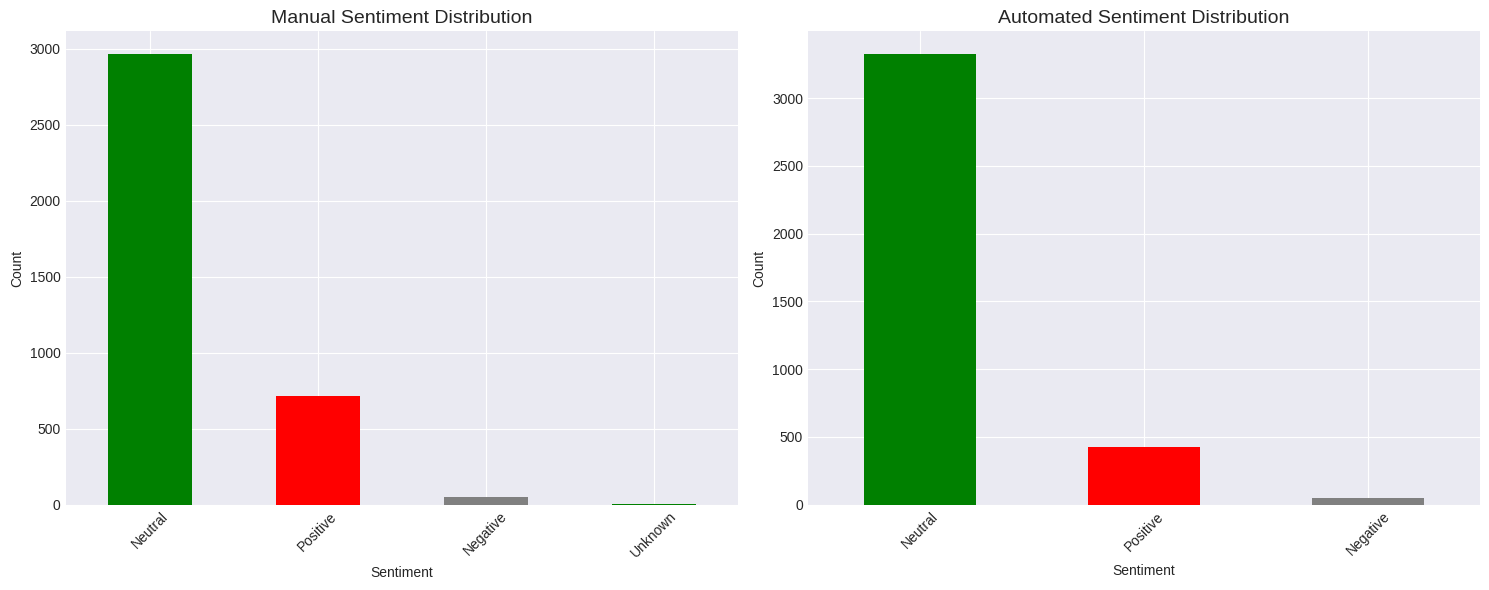

In [536]:
# Plot sentiment distribution charts
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
if not df['Sentiment'].isna().all():
    df['Sentiment'].dropna().value_counts().plot(
        kind='bar', ax=axes[0], color=['green', 'red', 'gray'])
    axes[0].set_title('Manual Sentiment Distribution', fontsize=14)
    axes[0].set_xlabel('Sentiment')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
df['Auto_Sentiment'].value_counts().plot(
    kind='bar', ax=axes[1], color=['green', 'red', 'gray'])
axes[1].set_title('Automated Sentiment Distribution', fontsize=14)
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


In [537]:
# Show 5 examples where manual and auto sentiment differ
print("\n5 Examples where Manual and Auto Sentiment Differ:")
print("="*80)

mismatched = comparison_df[~comparison_df['Match']].head(5)

# Convert 'Headline' column to string type to avoid TypeError
mismatched['Headline'] = mismatched['Headline'].astype(str)

for idx, row in mismatched.iterrows():
    print(f"\nHeadline: {row['Headline'][:100]}...")
    print(f"Manual Sentiment: {row['Sentiment']}")
    print(f"Auto Sentiment: {row['Auto_Sentiment']}")
    print("-"*80)


5 Examples where Manual and Auto Sentiment Differ:

Headline: nan...
Manual Sentiment: Positive
Auto Sentiment: Neutral
--------------------------------------------------------------------------------

Headline: nan...
Manual Sentiment: Positive
Auto Sentiment: Neutral
--------------------------------------------------------------------------------

Headline: Purple Heart Day is coming to honor America’s wounded veterans...
Manual Sentiment: Positive
Auto Sentiment: Neutral
--------------------------------------------------------------------------------

Headline: Trump’s Tariff Deadline Nears: India, Brazil Face Levies, Trade War Risks Rise...
Manual Sentiment: Negative
Auto Sentiment: Neutral
--------------------------------------------------------------------------------

Headline: Đối Thoại Điểm Tin ngày 31 tháng 07 năm 2025...
Manual Sentiment: Negative
Auto Sentiment: Neutral
--------------------------------------------------------------------------------


In [538]:
# Save to Excel
output_path = os.path.join(folder_path, "merged_cleaned_dataset.xlsx")
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="Cleaned", index=False)
    duplicates_df.to_excel(writer, sheet_name="Duplicates", index=False)

# 🧩 **Challenge 3: Trend Visualization**

---

### 🗂️ **Groupby Aggregation**

In [539]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
for col in ['twitter_social_echo', 'facebook_social_echo']:
    if col not in df.columns:
        df[col] = 0

# --- Pre-aggregations with groupby

# Trendline
daily_counts = df.groupby(['date', 'brand']).size().reset_index(name='count')
pivot_df = daily_counts.pivot(index='date', columns='brand', values='count').fillna(0)

# Sentiment analysis
sentiment_dist = (
    df.groupby(['brand', 'auto_sentiment', 'month'])
      .size()
      .reset_index(name='count')
)

top_sources = (
    df.groupby(['brand', 'source'])
      .agg(volume=('source', 'size'), reach=('reach', 'sum'))
      .reset_index()
      .sort_values(['brand', 'volume'], ascending=[True, False])
      .groupby('brand')
      .head(10)
)

media_type_counts = (
    df.groupby(['brand', 'media_type']).size().reset_index(name='count')
)

geo_trends = (
    df.groupby(['brand', 'country', 'subregion']).size().reset_index(name='count')
    if 'country' in df.columns and 'subregion' in df.columns else pd.DataFrame()
)

engagement_trends = df.groupby(['brand', 'date'])[
    ['reach', 'twitter_social_echo', 'facebook_social_echo']
].sum().reset_index()


### 📈 **Daily Trendline**

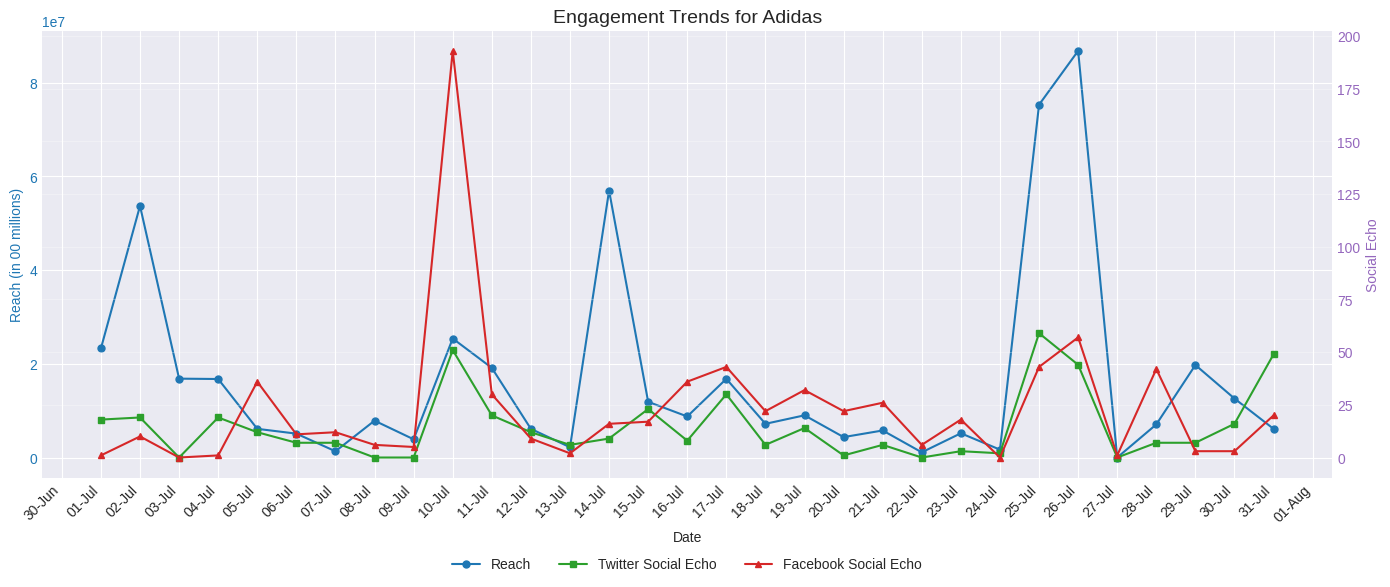

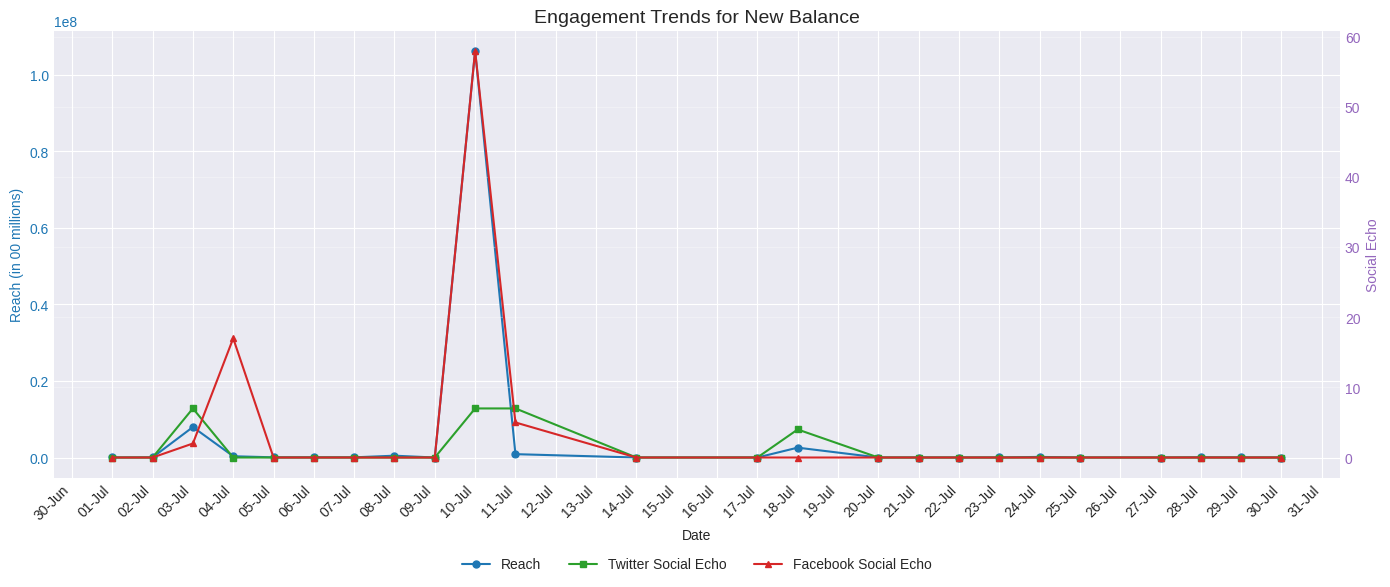

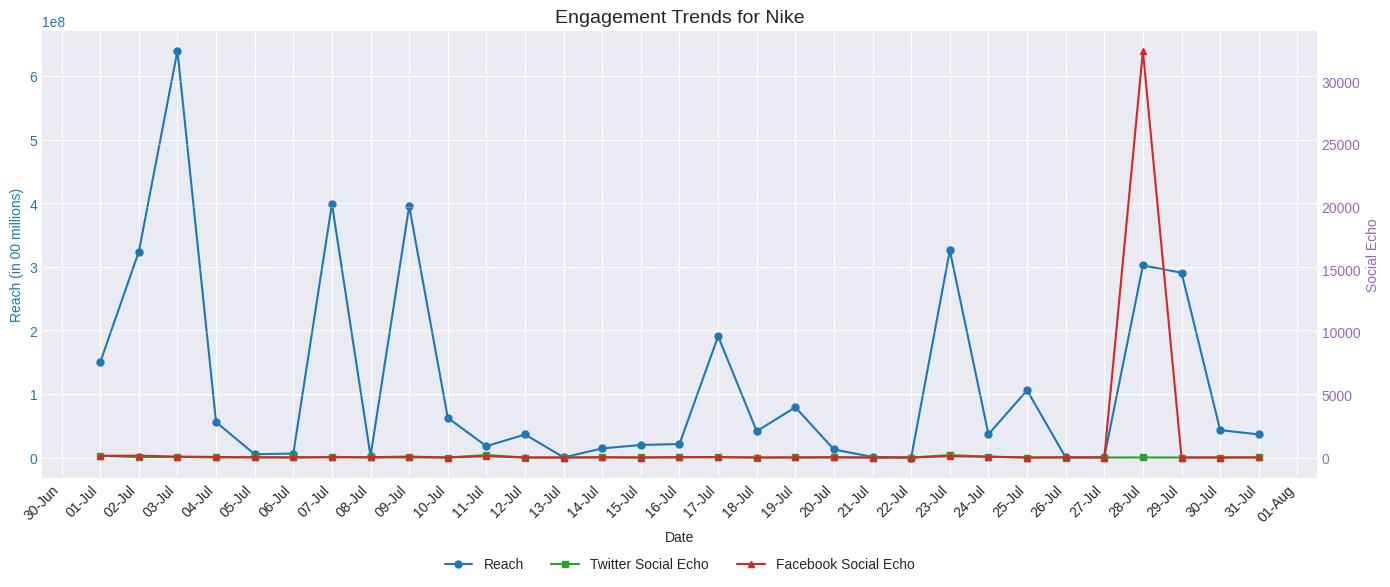

In [540]:
# Plot engagement trends for each brand
brands = engagement_trends['brand'].unique()
for brand in brands:
    brand_engagement = engagement_trends[engagement_trends['brand'] == brand].copy()

    fig, ax1 = plt.subplots(figsize=(14,6))

    # Primary y-axis: Reach
    ax1.plot(
        brand_engagement['date'],
        brand_engagement['reach'],
        label='Reach',
        color='tab:blue',
        linewidth=1.5,
        marker='o',
        markersize=5
    )
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Reach (in 00 millions)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Format x-axis
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=45, ha='right')

    # Secondary y-axis: Social Echo
    ax2 = ax1.twinx()
    ax2.plot(
        brand_engagement['date'],
        brand_engagement['twitter_social_echo'],
        label='Twitter Social Echo',
        color='tab:green',
        linewidth=1.5,
        marker='s',
        markersize=5
    )
    ax2.plot(
        brand_engagement['date'],
        brand_engagement['facebook_social_echo'],
        label='Facebook Social Echo',
        color='tab:red',
        linewidth=1.5,
        marker='^',
        markersize=5
    )
    ax2.set_ylabel("Social Echo", color='tab:purple')
    ax2.tick_params(axis='y', labelcolor='tab:purple')

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.title(f"Engagement Trends for {brand}", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    save_and_show_plot(fig, "Engagement Trends.png")

### 🙂 **Sentiment Analysis**

In [541]:
# Define colors for sentiment categories
colors = {
    "Positive": "green",
    "Negative": "red",
    "Neutral": "gray",
    "Unknown": "orange" # there should be no unknown
}

def plot_sentiment_all_brands():
    for brand in sentiment_dist["brand"].unique():
        brand_sentiment = sentiment_dist[
            sentiment_dist["brand"].str.strip().str.lower() == brand.strip().lower()
        ]
        if brand_sentiment.empty:
            print(f"⚠️ No sentiment data found for {brand}")
            continue

        sentiment_counts = brand_sentiment.set_index("auto_sentiment")["count"]

        # Match colors to sentiment order
        sentiment_colors = [colors.get(s, "lightblue") for s in sentiment_counts.index]

        # Donut chart
        fig, ax = plt.subplots(figsize=(7,7))
        wedges, texts = ax.pie(
            sentiment_counts,
            colors=sentiment_colors,
            startangle=140,
            wedgeprops=dict(width=0.35),
        )

        # White circle in the middle
        centre_circle = plt.Circle((0,0),0.65,fc="white")
        fig.gca().add_artist(centre_circle)

        # Add leader lines + custom labels
        total = sentiment_counts.sum()
        for i, (wedge, count) in enumerate(zip(wedges, sentiment_counts)):
            ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
            x = np.cos(np.deg2rad(ang))
            y = np.sin(np.deg2rad(ang))
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            ax.annotate(
                f"{sentiment_counts.index[i]}: {count} ({count/total:.1%})",
                xy=(x, y),
                xytext=(1.2*np.sign(x), 1.2*y),
                horizontalalignment={-1: "right", 1: "left"}[int(np.sign(x))],
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle, color="black"),
                fontsize=11
            )

        plt.title(f"Sentiment Analysis - {brand}", fontsize=14)
        plt.show()

# Run the loop for all brands
save_and_show_plot(fig, "Sentiment_AllBrands.png")


In [542]:
def plot_sentiment_monthly_stack():
    # Ensure "month" column exists
    if "month" not in sentiment_dist.columns:
        raise ValueError("⚠️ sentiment_dist must contain a 'month' column (values 1–12)")

    month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for brand in sentiment_dist["brand"].unique():
        brand_data = sentiment_dist[
            sentiment_dist["brand"].str.strip().str.lower() == brand.strip().lower()
        ]

        if brand_data.empty:
            print(f"⚠️ No sentiment data found for {brand}")
            continue

        # Pivot: months as rows, sentiments as columns
        pivot_df = brand_data.pivot_table(
            index="month",
            columns="auto_sentiment",
            values="count",
            aggfunc="sum",
            fill_value=0
        ).reindex(range(1, 13), fill_value=0)  # ensure all months included

        # Reorder columns to match color dict
        pivot_df = pivot_df.reindex(columns=colors.keys(), fill_value=0)

        # Plot stacked bar
        ax = pivot_df.plot(
            kind="bar",
            stacked=True,
            figsize=(12,6),
            color=[colors[s] for s in pivot_df.columns]
        )

        # X-axis labels = months
        ax.set_xticks(range(12))
        ax.set_xticklabels(month_labels, rotation=45)

        plt.title(f"M-o-M Sentiment Distribution - {brand}", fontsize=14)
        plt.xlabel("Month")
        plt.ylabel("Mentions")
        plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

save_and_show_plot(fig, "mom_sentiment.png")


### 📰 **Top Sources**

In [543]:
def plot_top_sources_all_brands():
    for brand in top_sources["brand"].unique():
        brand_sources = top_sources[top_sources["brand"] == brand]

        if brand_sources.empty:
            print(f"⚠️ No source data for {brand}")
            continue

        plt.figure(figsize=(8,4))
        plt.bar(
            brand_sources["source"],
            brand_sources["volume"],
            color="skyblue"
        )
        plt.title(f"{brand} - Top 10 Sources (by Volume)")
        plt.xlabel("Source")
        plt.ylabel("Volume")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
save_and_show_plot(fig, "Top_Sources.png")

In [544]:
def plot_media_type_by_brand(df_agg):
    # Pivot to get source_type as columns
    pivot_df = df_agg.pivot(index="brand", columns="media_type", values="count").fillna(0)

    # Plot stacked bar
    ax = pivot_df.plot(
        kind="bar",
        stacked=True,
        figsize=(10,6)
    )

    plt.title("Media Type SOV", fontsize=14)
    plt.xlabel("Brand")
    plt.ylabel("Mentions")
    plt.legend(title="Media Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

save_and_show_plot(fig, "media_SOV.png")

### 🌍 **Geographic Trends**

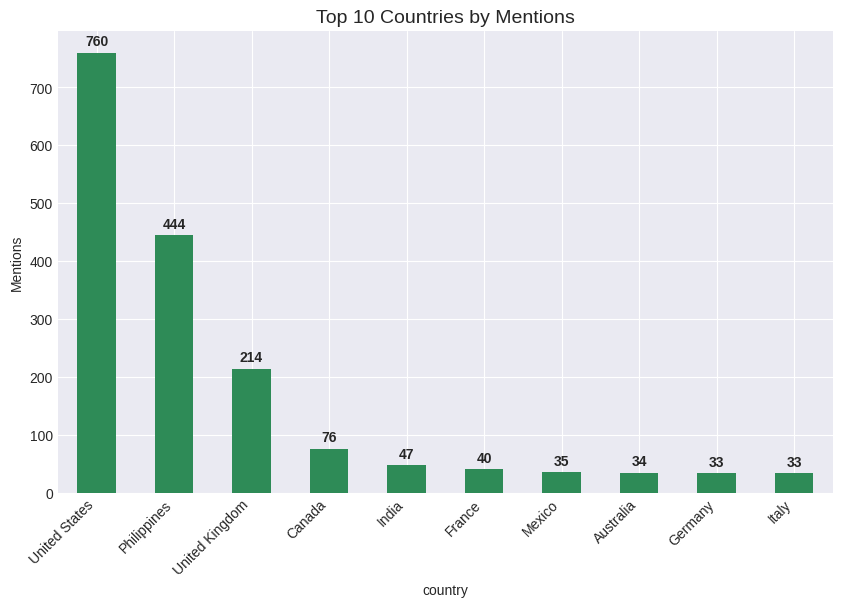

In [545]:
# Exclude "Unknown" before counting
top_countries = df[df['country'] != "Unknown"]['country'].value_counts().head(10)

# Bar chart
plt.figure(figsize=(10,6))
ax = top_countries.plot(kind='bar', color='seagreen')

# Title & labels
plt.title("Top 10 Countries by Mentions", fontsize=14)
plt.ylabel("Mentions")
plt.xticks(rotation=45, ha='right')

# Add value labels outside end
for i, v in enumerate(top_countries):
    ax.text(i, v + (max(top_countries) * 0.01),
            str(v),
            ha='center', va='bottom', fontsize=10, fontweight='bold')

save_and_show_plot(fig, "Top_Countries.png")

### 👍 **Engagement Trends**

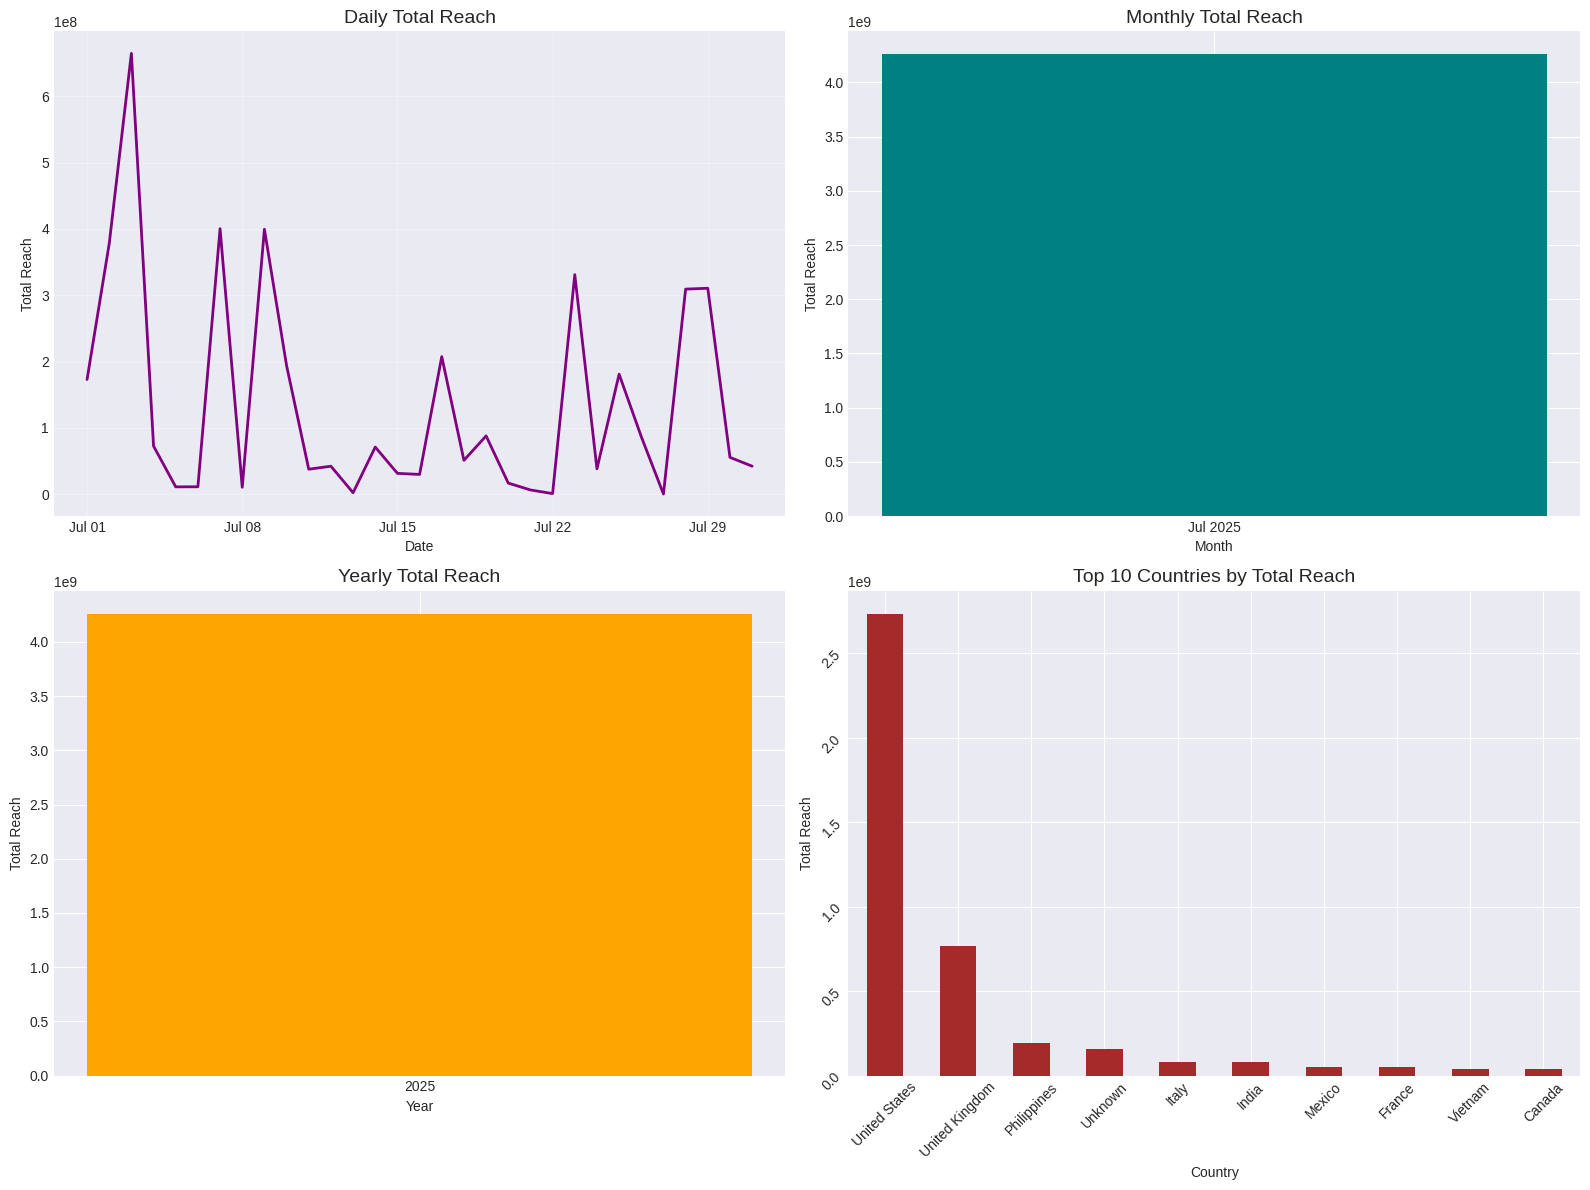

In [546]:
# Ensure 'date' column is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Daily reach
daily_reach = df.groupby('date')['reach'].sum().reset_index()

# Monthly reach (using existing year and month columns)
monthly_reach = df.groupby(['year', 'month'])['reach'].sum().reset_index()
# Create a datetime column for plotting
monthly_reach['date'] = pd.to_datetime(monthly_reach.assign(day=1)[['year','month','day']])

# Yearly reach
yearly_reach = df.groupby('year')['reach'].sum().reset_index()

# Country reach
country_reach = df.groupby('country')['reach'].sum().sort_values(ascending=False).head(10)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Daily reach trendline
axes[0, 0].plot(daily_reach['date'], daily_reach['reach'], color='purple', linewidth=2)
axes[0, 0].set_title('Daily Total Reach', fontsize=14)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Reach')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
axes[0, 0].xaxis.set_major_locator(mdates.WeekdayLocator())

# 2. Monthly reach
axes[0, 1].bar(monthly_reach['date'], monthly_reach['reach'], color='teal')
axes[0, 1].set_title('Monthly Total Reach', fontsize=14)
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Total Reach')
axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[0, 1].xaxis.set_major_locator(mdates.MonthLocator())

# 3. Yearly reach
axes[1, 0].bar(yearly_reach['year'], yearly_reach['reach'], color='orange')
axes[1, 0].set_title('Yearly Total Reach', fontsize=14)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Total Reach')
axes[1, 0].set_xticks(yearly_reach['year'])
axes[1, 0].set_xticklabels(yearly_reach['year'].astype(str))

# 4. Country reach
country_reach.plot(kind='bar', ax=axes[1, 1], color='brown')
axes[1, 1].set_title('Top 10 Countries by Total Reach', fontsize=14)
axes[1, 1].set_xlabel('Country')
axes[1, 1].set_ylabel('Total Reach')
axes[1, 1].tick_params(rotation=45)

plt.tight_layout()
save_and_show_plot(fig, "engagement_trends.png")


# 🧩 **Challenge 4: Topic Identification**

---

## 🔍 Keyword Analysis

In [547]:
# Process Keywords column
print("Analyzing Keywords...")

# Extract all keywords
all_keywords = []
for keywords in df['keywords'].dropna():
    # Try different delimiters
    if ',' in str(keywords):
        keyword_list = str(keywords).split(',')
    elif ';' in str(keywords):
        keyword_list = str(keywords).split(';')
    else:
        keyword_list = [str(keywords)]

    # Clean and add keywords
    all_keywords.extend([k.strip() for k in keyword_list if k.strip()])

# Count keyword occurrences
keyword_counts = Counter(all_keywords)
top_keywords = keyword_counts.most_common(10)

print(f"Total unique keywords: {len(keyword_counts)}")
print(f"Total keyword occurrences: {len(all_keywords)}")
print("\nTop 10 Keywords:")
for keyword, count in top_keywords:
    print(f"{keyword}: {count}")

Analyzing Keywords...
Total unique keywords: 13
Total keyword occurrences: 8078

Top 10 Keywords:
Philippines: 3742
Nike: 3447
Adidas: 357
adidas: 147
New Balance: 140
nike: 76
philippines: 69
NIKE: 58
PHILIPPINES: 20
ADIDAS: 9


## 🔍 Key Phrases Analysis

In [548]:
# Process Key Phrases column
print("\nAnalyzing Key Phrases...")

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
# Extract all key phrases
all_phrases = []
for phrases in df['key_phrases'].dropna():
    # Try different delimiters
    if ',' in str(phrases):
        phrase_list = str(phrases).split(',')
    elif ';' in str(phrases):
        phrase_list = str(phrases).split(';')
    else:
        phrase_list = [str(phrases)]

    # Clean and add phrases
    all_phrases.extend([p.strip() for p in phrase_list if p.strip()])

# Count phrase occurrences
phrase_counts = Counter(all_phrases)
top_phrases = phrase_counts.most_common(10)

print(f"Total unique phrases: {len(phrase_counts)}")
print(f"Total phrase occurrences: {len(all_phrases)}")
print("\nTop 10 Key Phrases:")
for phrase, count in top_phrases:
    print(f"{phrase}: {count}")


Analyzing Key Phrases...
Total unique phrases: 4148
Total phrase occurrences: 28004

Top 10 Key Phrases:
national flower: 1778
harvest: 1381
hair tie: 932
sampaguita: 762
old alexandra eala: 746
dream: 737
grass courts: 737
history: 737
full bloom: 735
home: 733


## 🔁 Keyword Frequency Chart

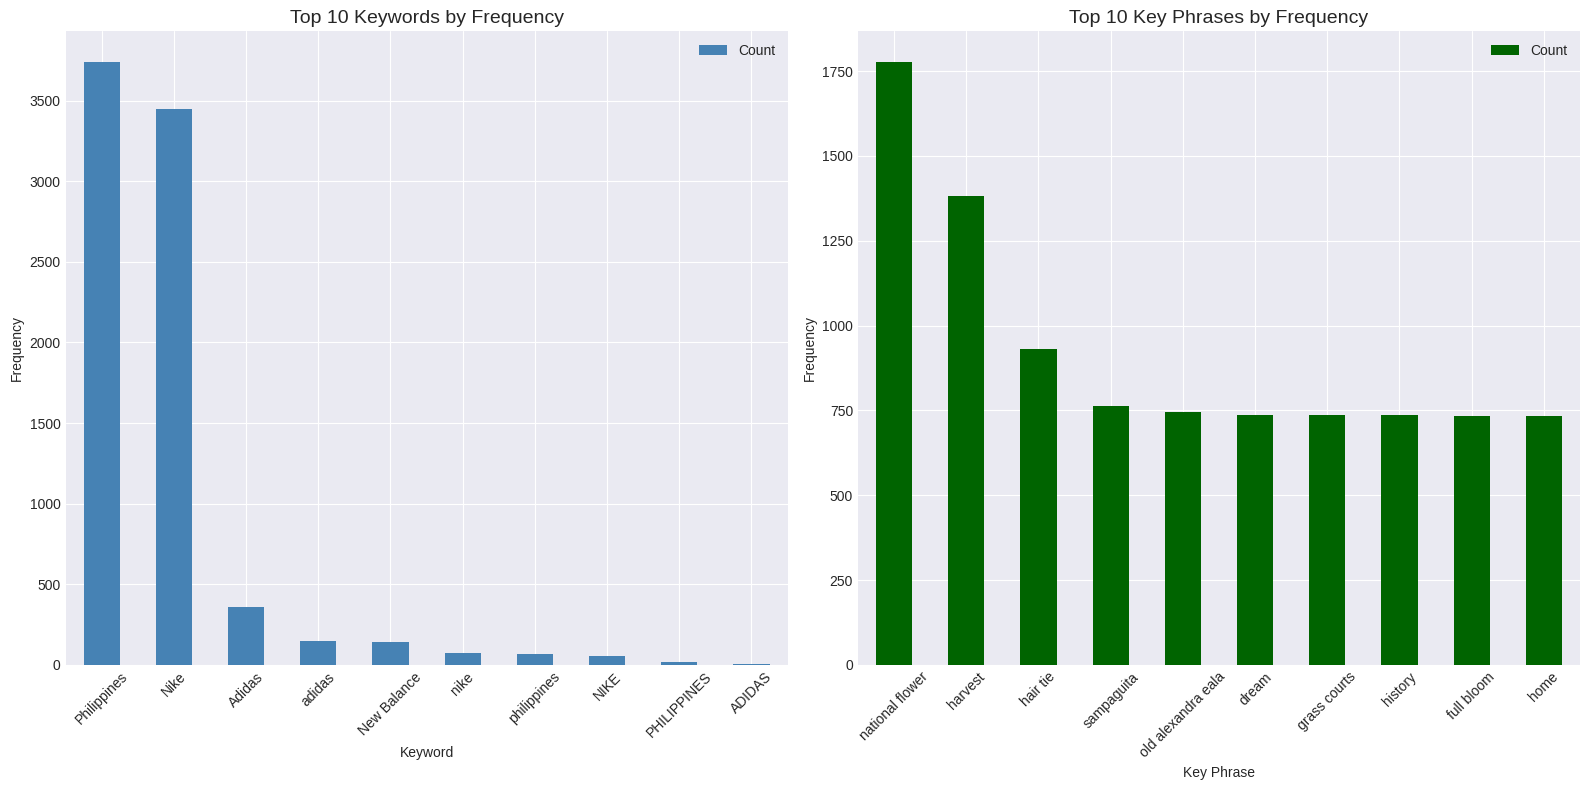

In [549]:
# Create keyword frequency chart
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Keywords bar chart
keywords_df = pd.DataFrame(top_keywords, columns=['Keyword', 'Count'])
keywords_df.plot(x='Keyword', y='Count', kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Top 10 Keywords by Frequency', fontsize=14)
axes[0].set_xlabel('Keyword')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(rotation=45, axis='x')

# Key phrases bar chart
phrases_df = pd.DataFrame(top_phrases, columns=['Phrase', 'Count'])
phrases_df.plot(x='Phrase', y='Count', kind='bar', ax=axes[1], color='darkgreen')
axes[1].set_title('Top 10 Key Phrases by Frequency', fontsize=14)
axes[1].set_xlabel('Key Phrase')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(rotation=45, axis='x')

plt.tight_layout()
save_and_show_plot(fig, "key_phrases.png")

## 💬 Most Used Keyword by Sources

In [550]:
# Analyze which sources use which keywords most
print("\nKeyword Usage by Source:")

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Create a mapping of sources to their top keywords
source_keywords = {}
for idx, row in df.iterrows():
    source = row['source']
    keywords_str = row['keywords']

    if pd.notna(keywords_str) and pd.notna(source):
        # Extract keywords for this row
        if ',' in str(keywords_str):
            keywords = [k.strip() for k in str(keywords_str).split(',')]
        elif ';' in str(keywords_str):
            keywords = [k.strip() for k in str(keywords_str).split(';')]
        else:
            keywords = [str(keywords_str).strip()]

        # Add to source mapping
        if source not in source_keywords:
            source_keywords[source] = []
        source_keywords[source].extend(keywords)

# Get top keywords for top 5 sources
top_5_sources = df['source'].value_counts().head(5).index

print("\nTop Keywords by Top 5 Sources:")
for source in top_5_sources:
    if source in source_keywords:
        source_keyword_counts = Counter(source_keywords[source])
        top_3_keywords = source_keyword_counts.most_common(3)
        print(f"\n{source}:")
        for keyword, count in top_3_keywords:
            print(f"  - {keyword}: {count}")


Keyword Usage by Source:

Top Keywords by Top 5 Sources:

Twitter:
  - Philippines: 2211
  - Nike: 2178
  - Adidas: 43

Tiktok:
  - Philippines: 140
  - Nike: 88
  - adidas: 36

Youtube:
  - Philippines: 43
  - philippines: 32
  - Nike: 31

Forums:
  - Philippines: 34
  - Adidas: 20
  - Nike: 9

Facebook:
  - Philippines: 24
  - Nike: 20
  - Adidas: 7


# 🧩 **Challenge 5: Word Cloud Visualization**

---

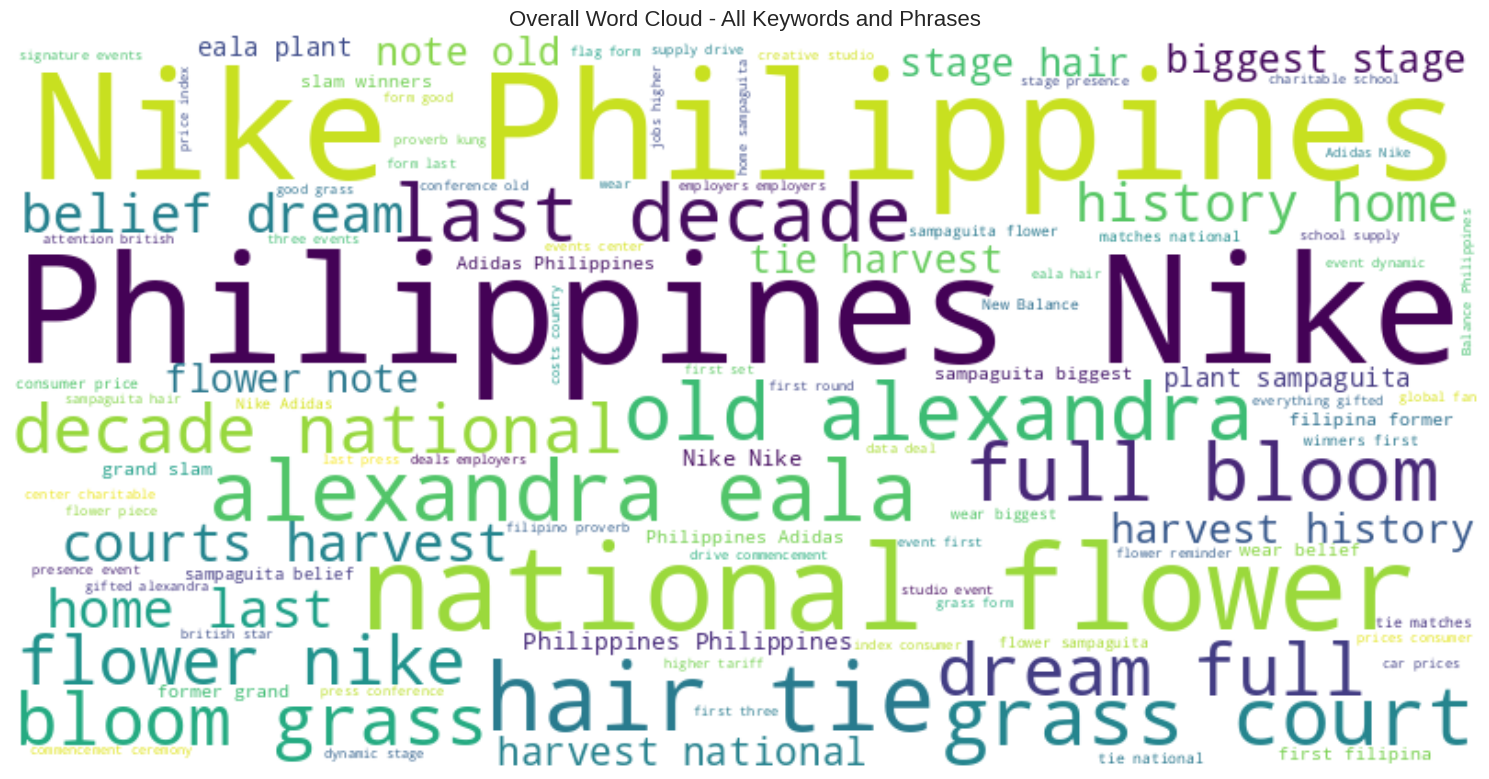

In [551]:
# Prepare text for word clouds
# Combine keywords and key phrases
all_text_keywords = ' '.join(all_keywords)
all_text_phrases = ' '.join(all_phrases)
combined_text = all_text_keywords + ' ' + all_text_phrases

# Create overall word cloud
plt.figure(figsize=(15, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     colormap='viridis', max_words=100).generate(combined_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Overall Word Cloud - All Keywords and Phrases', fontsize=16)
plt.tight_layout()
save_and_show_plot(fig, "word_cloud.png")

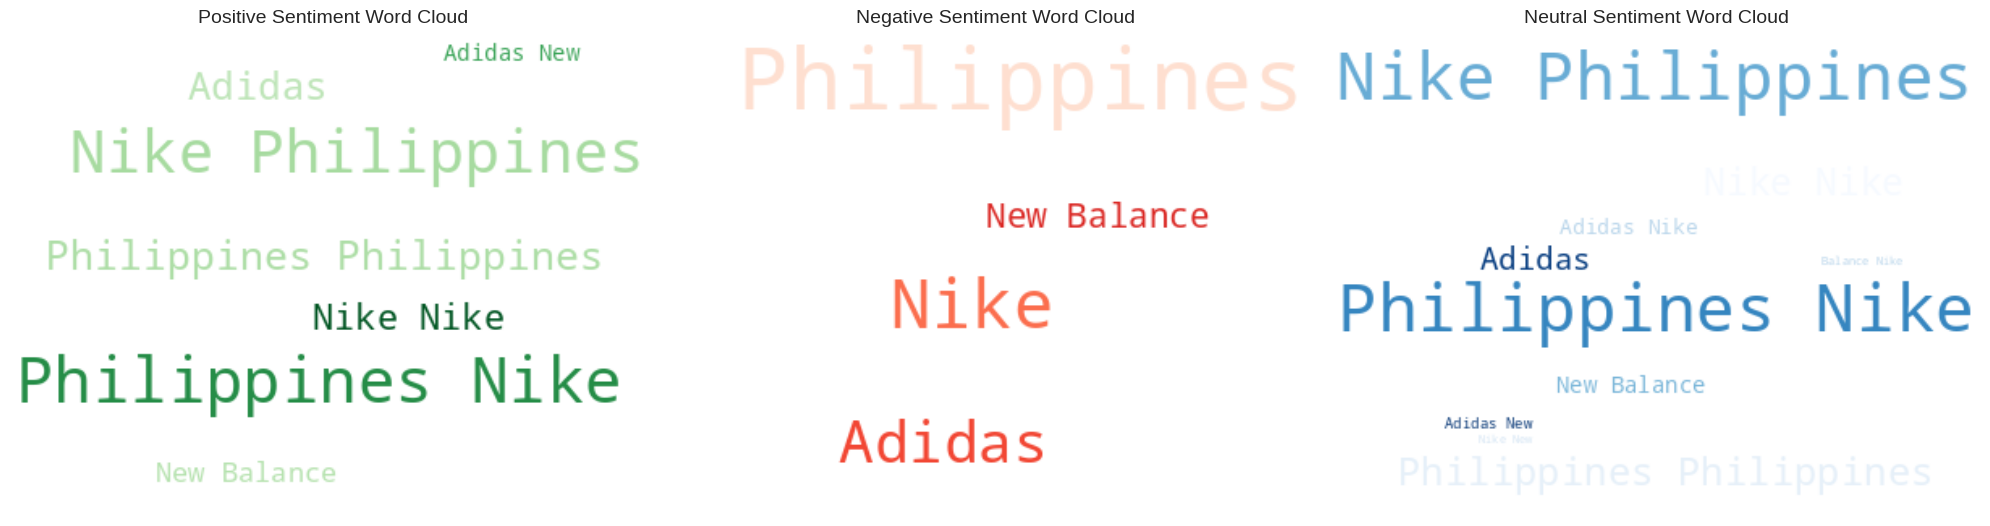

In [552]:
# Create sentiment-specific word clouds
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sentiments = ['Positive', 'Negative', 'Neutral']
colors = ['Greens', 'Reds', 'Blues']

for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
    # Get keywords for this sentiment
    sentiment_df = df[df['auto_sentiment'] == sentiment]
    sentiment_keywords = []

    for keywords in sentiment_df['keywords'].dropna():
        if ',' in str(keywords):
            keyword_list = str(keywords).split(',')
        elif ';' in str(keywords):
            keyword_list = str(keywords).split(';')
        else:
            keyword_list = [str(keywords)]
        sentiment_keywords.extend([k.strip() for k in keyword_list if k.strip()])

    if sentiment_keywords:
        sentiment_text = ' '.join(sentiment_keywords)
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                            colormap=color, max_words=50).generate(sentiment_text)
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'{sentiment} Sentiment Word Cloud', fontsize=14)
    else:
        axes[idx].text(0.5, 0.5, 'No keywords available',
                      horizontalalignment='center', verticalalignment='center')
        axes[idx].axis('off')
        axes[idx].set_title(f'{sentiment} Sentiment Word Cloud', fontsize=14)

plt.tight_layout()
save_and_show_plot(fig, "cloud_sentiment.png")

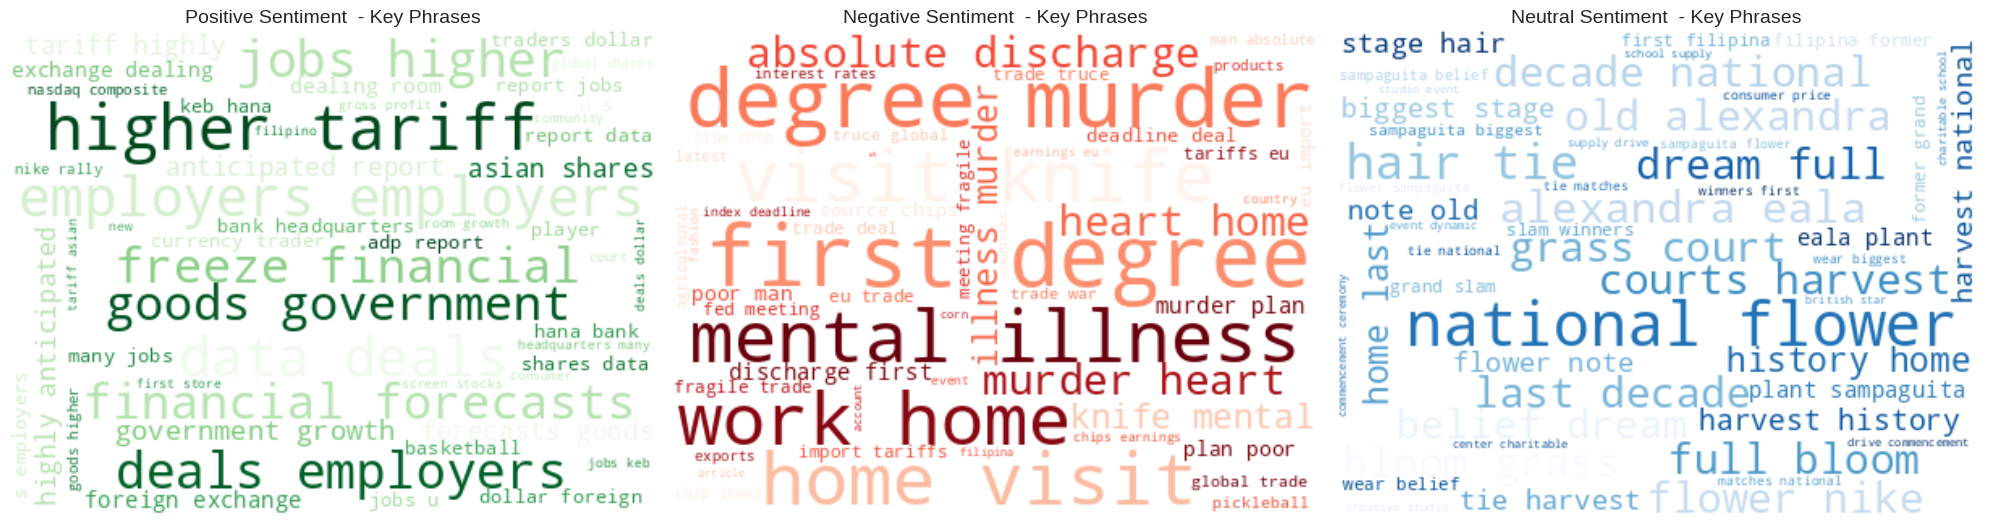

In [553]:
# Create sentiment-specific word clouds
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sentiments = ['Positive', 'Negative', 'Neutral']
colors = ['Greens', 'Reds', 'Blues']

for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
    # Filter rows by sentiment
    sentiment_df = df[df['auto_sentiment'] == sentiment]
    sentiment_phrases = []

    for phrases in sentiment_df['key_phrases'].dropna():
        if ',' in str(phrases):
            phrase_list = str(phrases).split(',')
        elif ';' in str(phrases):
            phrase_list = str(phrases).split(';')
        else:
            phrase_list = [str(phrases)]
        sentiment_phrases.extend([p.strip() for p in phrase_list if p.strip()])

    if sentiment_phrases:
        # Join phrases into one big text for word cloud
        sentiment_text = ' '.join(sentiment_phrases)
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                              colormap=color, max_words=50).generate(sentiment_text)
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'{sentiment} Sentiment  - Key Phrases', fontsize=14)
    else:
        axes[idx].text(0.5, 0.5, 'No key phrases available',
                       horizontalalignment='center', verticalalignment='center')
        axes[idx].axis('off')
        axes[idx].set_title(f'{sentiment} Sentiment - Key Phrases', fontsize=14)

plt.tight_layout()
save_and_show_plot(fig, "cloud_phrases.png")


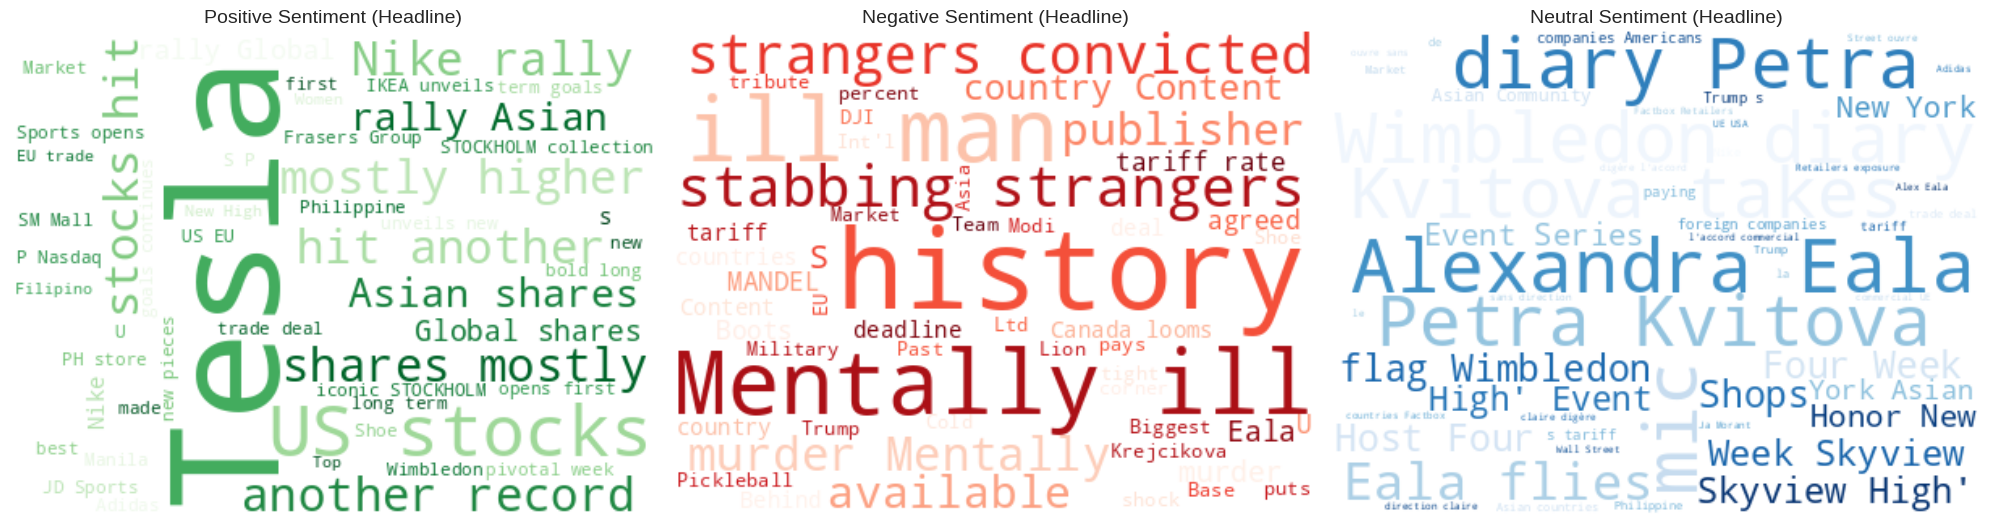

In [554]:
# Create sentiment-specific word clouds using Headline column
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sentiments = ['Positive', 'Negative', 'Neutral']
colors = ['Greens', 'Reds', 'Blues']

for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
    # Filter rows by sentiment
    sentiment_df = df[df['auto_sentiment'] == sentiment]

    # Combine all headlines into one text
    headlines_text = ' '.join(sentiment_df['headline'].dropna().astype(str))

    if headlines_text.strip():
        # Generate word cloud
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                              colormap=color, max_words=50).generate(headlines_text)
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'{sentiment} Sentiment (Headline)', fontsize=14)
    else:
        # Handle case with no data
        axes[idx].text(0.5, 0.5, 'No headlines available',
                       horizontalalignment='center', verticalalignment='center')
        axes[idx].axis('off')
        axes[idx].set_title(f'{sentiment} Sentiment (Headline)', fontsize=14)

plt.tight_layout()
save_and_show_plot(fig, "cloud_sentiment.png")

# 🧩 **Challenge 6: Summary Insights**

---

In [555]:
# Question 1: Top 5 sources by number of stories
top_5_sources_list = df['source'].value_counts().head(5)
print("1. Top 5 Sources by Number of Stories:")
print("="*50)
for i, (source, count) in enumerate(top_5_sources_list.items(), 1):
    print(f"{i}. {source}: {count} stories")
print()

1. Top 5 Sources by Number of Stories:
1. Twitter: 2218 stories
2. Tiktok: 141 stories
3. Youtube: 68 stories
4. Forums: 35 stories
5. Facebook: 30 stories



In [556]:
# Question 2: Country with most positive sentiment stories
positive_by_country = df[df['auto_sentiment'] == 'Positive']['country'].value_counts()
print("2. Country with Most Positive Sentiment Stories:")
print("="*50)
if not positive_by_country.empty:
    top_positive_country = positive_by_country.index[0]
    top_positive_count = positive_by_country.iloc[0]
    print(f"{top_positive_country}: {top_positive_count} positive stories")
    print("\nTop 5 countries by positive stories:")
    for country, count in positive_by_country.head(5).items():
        print(f"  - {country}: {count}")
print()

2. Country with Most Positive Sentiment Stories:
United States: 215 positive stories

Top 5 countries by positive stories:
  - United States: 215
  - Philippines: 78
  - Unknown: 41
  - United Kingdom: 25
  - Canada: 17



In [557]:
# Question 3: Most common keyword/topic
print("3. Most Common Keyword/Topic:")
print("="*50)
if top_keywords:
    most_common_keyword = top_keywords[0]
    print(f"Most common keyword: '{most_common_keyword[0]}' (appears {most_common_keyword[1]} times)")
    print("\nTop 5 keywords:")
    for keyword, count in top_keywords[:5]:
        print(f"  - {keyword}: {count}")
print()

3. Most Common Keyword/Topic:
Most common keyword: 'Philippines' (appears 3742 times)

Top 5 keywords:
  - Philippines: 3742
  - Nike: 3447
  - Adidas: 357
  - adidas: 147
  - New Balance: 140



In [558]:
# Question 4: Dates with most stories

date_story_count = df.groupby(['date']).size().reset_index(name='Count')
date_story_count = date_story_count.sort_values('Count', ascending=False)
print("4. Date with Most Stories:")
print("="*50)
if not date_story_count.empty:
    top_date = date_story_count.iloc[0]
    print(f"{str(top_date['date'])[:-8]}: {top_date['Count']} stories")
    print("\nTop 5 dates by story count:")
    for _, row in date_story_count.head(5).iterrows():
        print(f"  - {str(row['date'])[:-8]}: {row['Count']} stories")
print()

4. Date with Most Stories:
2025-07-01 : 1243 stories

Top 5 dates by story count:
  - 2025-07-01 : 1243 stories
  - 2025-07-02 : 1151 stories
  - 2025-07-03 : 301 stories
  - 2025-07-24 : 100 stories
  - 2025-07-28 : 76 stories



In [559]:
# Question 4: Month with most stories
month_story_count = df.groupby(['year', 'monthname', 'month']).size().reset_index(name='Count')
month_story_count = month_story_count.sort_values('Count', ascending=False)

print("4. Month with Most Stories:")
print("="*50)
if not month_story_count.empty:
    top_month = month_story_count.iloc[0]
    print(f"{top_month['monthname']} {int(top_month['year'])}: {top_month['Count']} stories")
    print("\nTop 5 months by story count:")
    for _, row in month_story_count.head(5).iterrows():
        print(f"  - {row['monthname']} {int(row['year'])}: {row['Count']} stories")
print()

4. Month with Most Stories:
July 2025: 3806 stories

Top 5 months by story count:
  - July 2025: 3806 stories



In [560]:
# Question 5: Source with highest average reach
# Calculate average total reach by source
avg_reach_by_source = df.groupby('source')['reach'].agg(['mean', 'count'])
avg_reach_by_source = avg_reach_by_source[avg_reach_by_source['count'] >= 5]  # Filter sources with at least 5 stories
avg_reach_by_source = avg_reach_by_source.sort_values('mean', ascending=False)

print("5. Source with Highest Average Reach:")
print("="*50)
if not avg_reach_by_source.empty:
    top_reach_source = avg_reach_by_source.index[0]
    top_reach_value = avg_reach_by_source.iloc[0]['mean']
    top_reach_count = avg_reach_by_source.iloc[0]['count']
    print(f"{top_reach_source}: {top_reach_value:,.0f} average reach (from {top_reach_count} stories)")
    print("\nTop 5 sources by average reach (min 5 stories):")
    for source in avg_reach_by_source.head(5).index:
        avg = avg_reach_by_source.loc[source, 'mean']
        count = avg_reach_by_source.loc[source, 'count']
        print(f"  - {source}: {avg:,.0f} (from {count} stories)")
print()

5. Source with Highest Average Reach:
MSN.com: 103,523,963 average reach (from 11.0 stories)

Top 5 sources by average reach (min 5 stories):
  - MSN.com: 103,523,963 (from 11 stories)
  - Daily Mail: 52,326,321 (from 7 stories)
  - Yahoo! Finance: 40,947,905 (from 12 stories)
  - Trading View: 24,757,377 (from 5 stories)
  - ABS CBN News: 5,778,456 (from 7 stories)



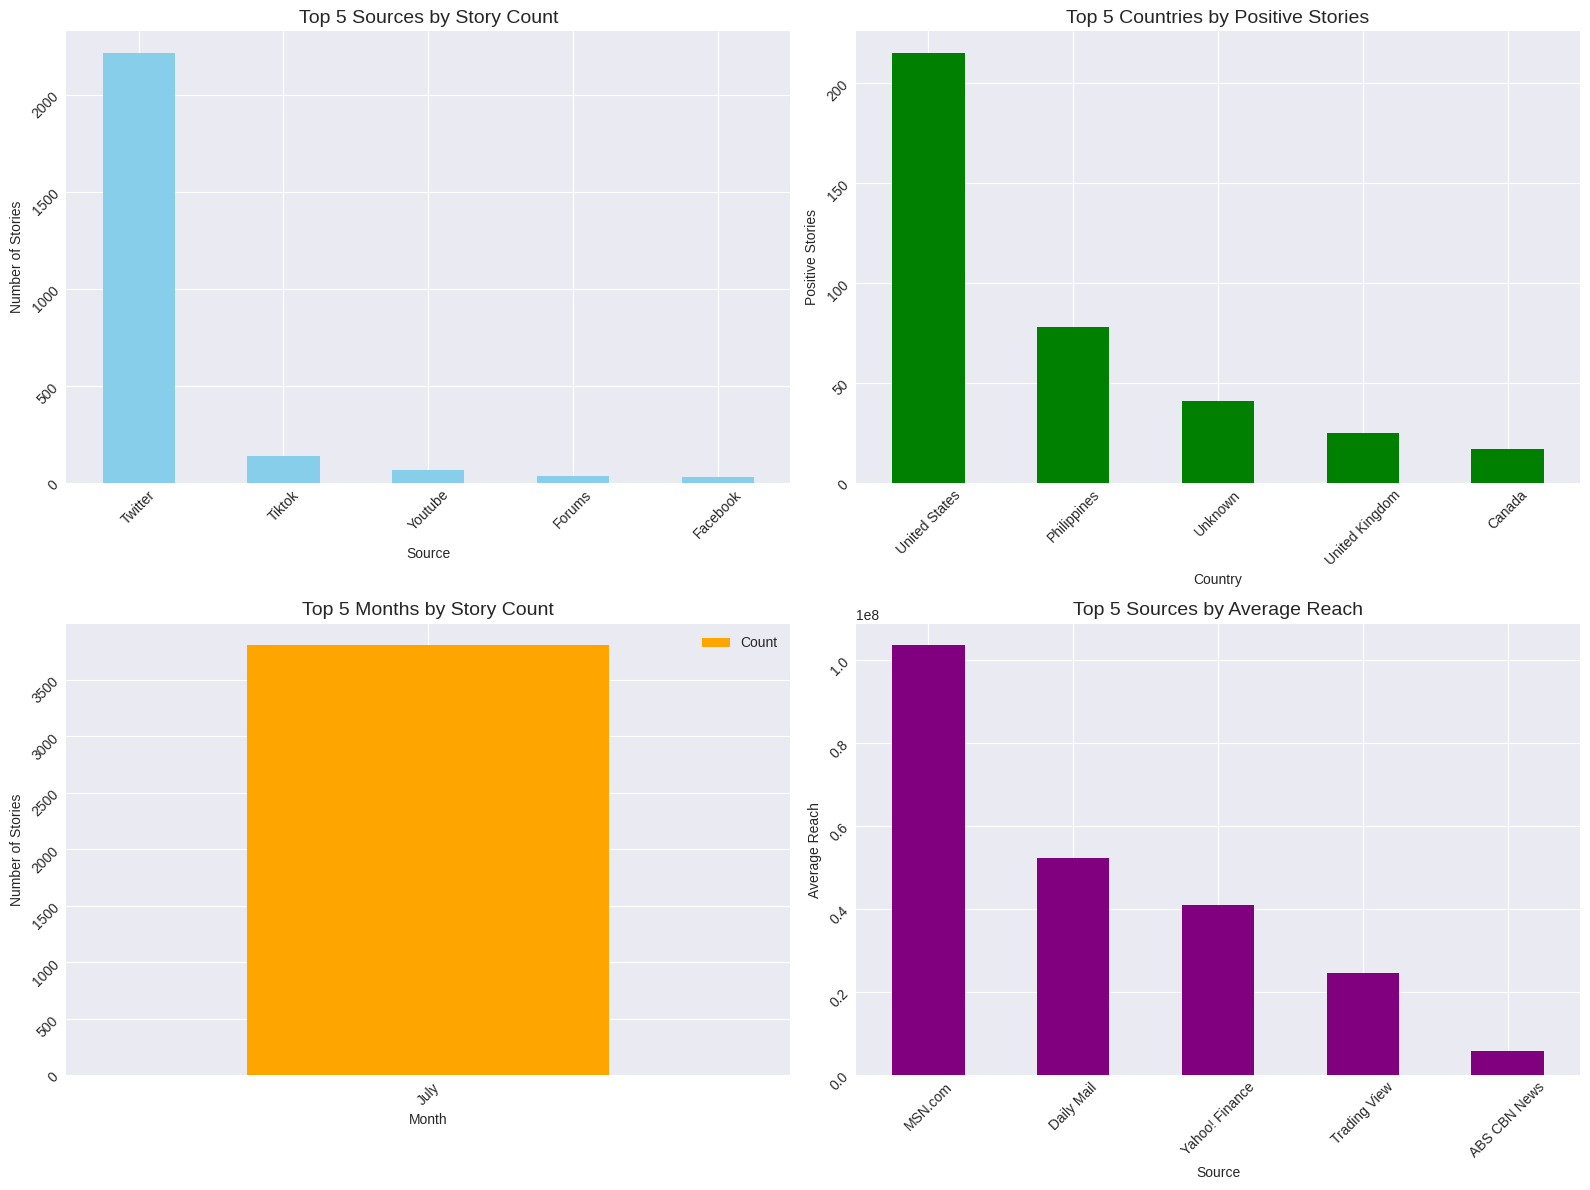

In [561]:
# Create summary visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top sources chart
top_5_sources_list.plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Top 5 Sources by Story Count', fontsize=14)
axes[0, 0].set_xlabel('Source')
axes[0, 0].set_ylabel('Number of Stories')
axes[0, 0].tick_params(rotation=45)

# Positive sentiment by country
positive_by_country.head(5).plot(kind='bar', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Top 5 Countries by Positive Stories', fontsize=14)
axes[0, 1].set_xlabel('Country')
axes[0, 1].set_ylabel('Positive Stories')
axes[0, 1].tick_params(rotation=45)

# Monthly story distribution
month_story_count.head(5).plot(x='monthname', y='Count', kind='bar', ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Top 5 Months by Story Count', fontsize=14)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Stories')
axes[1, 0].tick_params(rotation=45)

# Average reach by source
avg_reach_by_source.head(5)['mean'].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Top 5 Sources by Average Reach', fontsize=14)
axes[1, 1].set_xlabel('Source')
axes[1, 1].set_ylabel('Average Reach')
axes[1, 1].tick_params(rotation=45)

plt.tight_layout()
plt.show()

In [562]:
# 3 Interesting Findings & Recommendations
print("\n" + "="*70)
print("3 INTERESTING FINDINGS:")
print("="*70)

# Finding 1: Sentiment distribution
sentiment_pct = df['auto_sentiment'].value_counts(normalize=True) * 100
print(f"1. Sentiment Balance: {sentiment_pct.get('Positive', 0):.1f}% positive, "
      f"{sentiment_pct.get('Negative', 0):.1f}% negative, "
      f"{sentiment_pct.get('Neutral', 0):.1f}% neutral coverage")

# Finding 2: Coverage concentration
top_3_sources_pct = (top_5_sources_list.head(3).sum() / len(df)) * 100
print(f"2. Source Concentration: Top 3 sources account for {top_3_sources_pct:.1f}% of all coverage")

# Finding 3: Geographic focus
top_country_pct = (df['country'].value_counts().iloc[0] / len(df)) * 100
top_country_name = df['country'].value_counts().index[0]
print(f"3. Geographic Focus: {top_country_name} dominates with {top_country_pct:.1f}% of all stories")

print("\n" + "="*70)
print("RECOMMENDATIONS:")
print("="*70)
print("Based on the analysis, here are key recommendations for media monitoring:")
print("\n1. DIVERSIFY SOURCES: Consider monitoring more diverse news sources to reduce")
print("   concentration risk and get broader perspectives.")
print("\n2. FOCUS ON HIGH-REACH CONTENT: Prioritize monitoring and engagement with")
print(f"   sources like {avg_reach_by_source.index[0]} that have higher average reach.")
print("\n3. SENTIMENT TRACKING: Implement real-time sentiment monitoring to quickly")
print("   identify and respond to negative coverage trends.")
print("\n4. KEYWORD OPTIMIZATION: Focus content strategy around top keywords like")
print(f"   '{top_keywords[0][0]}' which appear most frequently in coverage.")
print("="*70)


3 INTERESTING FINDINGS:
1. Sentiment Balance: 11.2% positive, 1.4% negative, 87.4% neutral coverage
2. Source Concentration: Top 3 sources account for 63.8% of all coverage
3. Geographic Focus: Unknown dominates with 46.4% of all stories

RECOMMENDATIONS:
Based on the analysis, here are key recommendations for media monitoring:

1. DIVERSIFY SOURCES: Consider monitoring more diverse news sources to reduce
   concentration risk and get broader perspectives.

2. FOCUS ON HIGH-REACH CONTENT: Prioritize monitoring and engagement with
   sources like MSN.com that have higher average reach.

3. SENTIMENT TRACKING: Implement real-time sentiment monitoring to quickly
   identify and respond to negative coverage trends.

4. KEYWORD OPTIMIZATION: Focus content strategy around top keywords like
   'Philippines' which appear most frequently in coverage.


# 🧩 **Challenge 7: Export Results**

---

## 💾 Save Final Output

In [563]:
from openpyxl.styles import Font
# Save datasets + plots into the SAME Excel file
output_path = os.path.join(folder_path, "merged_cleaned_dataset.xlsx")

with pd.ExcelWriter(output_path, engine="openpyxl", mode="w") as writer:
    df.to_excel(writer, sheet_name="Cleaned", index=False)
    duplicates_df.to_excel(writer, sheet_name="Duplicates", index=False)

# Reopen workbook to insert plots
wb = load_workbook(output_path)
ws = wb.create_sheet("Visualizations")

row = 1
for f in plot_files:  # plot_files must be a list of saved PNG paths
    # --- Header from filename ---
    title = os.path.splitext(os.path.basename(f))[0]
    ws[f"A{row}"] = title.replace("_", " ").title()
    ws[f"A{row}"].font = Font(bold=True, size=14)

    # --- Load image ---
    img = XLImage(f)

    # Scale proportionally (bigger size than before)
    max_width = 700   # ~15 columns wide
    max_height = 400  # ~20 rows tall
    scale = min(max_width / img.width, max_height / img.height)
    img.width = int(img.width * scale)
    img.height = int(img.height * scale)

    # Insert image just below header
    ws.add_image(img, f"A{row+1}")

    # Add spacing (increase so charts don’t overlap)
    row += 30

# 🔑 Save again so Excel sees the new sheet
wb.save(output_path)

## 🧠 Memory Managment

*   Add memory usage monitoring and cleanup procedures

In [564]:
import psutil
import gc

# --- Memory monitoring function ---
def memory_usage(label="Current"):
    """Prints memory usage of the current process in MB"""
    process = psutil.Process()
    mem = process.memory_info().rss / (1024 * 1024)  # in MB
    print(f"[{label}] Memory Usage: {mem:.2f} MB")

# --- Cleanup function ---
def cleanup_memory(objs_to_delete=None, run_gc=True, label="Cleanup"):
    """
    Delete objects from memory and optionally run garbage collection.

    Parameters:
    -----------
    objs_to_delete : list[str], optional
        List of variable names (as strings) to delete from globals().
    run_gc : bool, default True
        Whether to force garbage collection after deleting objects.
    label : str, default "Cleanup"
        Label for memory usage printout.
    """
    if objs_to_delete:
        for obj in objs_to_delete:
            if obj in globals():
                del globals()[obj]
                print(f"Deleted object: {obj}")
    if run_gc:
        gc.collect()
    memory_usage(label)

    # After loading a dataframe
memory_usage("After loading df")

# After processing
memory_usage("After processing")

# Cleanup heavy variables
cleanup_memory(objs_to_delete=["df"], run_gc=True, label="After cleanup")


[After loading df] Memory Usage: 813.83 MB
[After processing] Memory Usage: 813.83 MB
Deleted object: df
[After cleanup] Memory Usage: 813.83 MB
